# Dogs vs. Cats  
<개와 고양이를 구분해 보자>

1. 데이터 준비 
2. CNN 처음 적용 
3. VGG 적용 (민욱 책임 테스트 결과 전달 받고 포기)
4. 다른 모델 적용 (경량화 모델 중 택일)
 - small Incetion V4

# 압축 파일 풀기
 - 코드는 민욱책임 코드 참조

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

import zipfile
import os, os.path

In [0]:

# 1. Authenticate and create the PyDrive client.# 1. Au 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1SDoU6rzXIl5t3pAJyXwidIQJAvRPFxPz'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.zip')
downloaded = drive.CreateFile({'id':'1rnh3ASbiBsGEOOLOv3D3nZbBxE7EOufE'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test.zip')

In [0]:
DataPath = './data'

In [0]:
def ExtractZip(zipPath, dataPath, dataType, dataNum):
    # 해당 폴더가 존재하는지 확인
    doExtract = True
    targetPath = dataPath + "/" + dataType
    if os.path.isdir(targetPath):
        numFile = len(os.listdir(targetPath))
        if numFile == dataNum:
            doExtract = False
    
    if doExtract == True:
        objZip = zipfile.ZipFile(zipPath)
        objZip.extractall(dataPath)
        print("[%s] is extracted to [%s](%d)." %(zipPath, targetPath, len(os.listdir(targetPath))))
    else:
        print("[%s] is already extracted to [%s](%d)." %(zipPath, targetPath, len(os.listdir(targetPath))))

In [9]:
# 압축 풀기
ExtractZip('./train.zip', DataPath, "train", 25000)
ExtractZip('./test.zip', DataPath, "test", 12500)

[./train.zip] is extracted to [./data/train](25000).
[./test.zip] is extracted to [./data/test](12500).


# 이미지 표시 해 보기

In [0]:
from IPython.display import Image

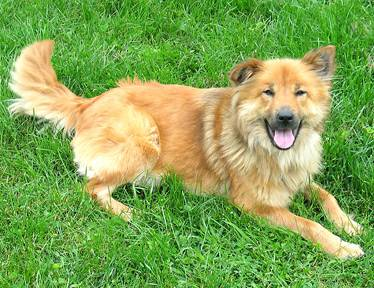

In [11]:
Image('/content/data/test/4.jpg')

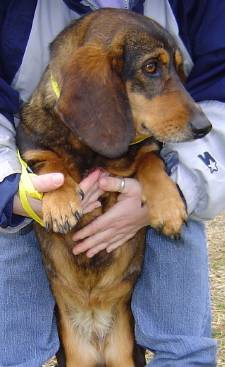

In [12]:
Image('./data/train/dog.222.jpg')

# 데이터 준비
 - 혜선 수석님 코드 참조

In [18]:
!pip install -U tqdm
!pip install -U ipywidgets

import os, cv2, random
import numpy as np
from tqdm import tqdm
from tqdm import trange, tnrange, tqdm_notebook
from ipywidgets import IntProgress
from time import sleep
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 112kB 2.6MB/s 
    100% |████████████████████████████████| 2.2MB 8.5MB/s 
Requirement not upgraded as not directly required: ipykernel>=4.5.1 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.6.1)
Requirement not upgraded as not directly required: nbformat>=4.2.0 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.4.0)
Requirement not upgraded as not directly required: traitlets>=4.3.1 in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (4.3.2)
Requirement not upgraded as not directly required: ipython>=4.0.0; python_version >= "3.3" in /usr/local/lib/python3.6/dist-packages (from ipywidgets) (5.5.0)
Requirement not upgraded as not directly required: notebook>=4.4.1 in /usr/local/lib/python3.6/dist-packages (from widgetsnbextension~=3.2.0->ipywidgets) (5.2.2)
Requirement not upgraded as not directly required: tornado>=4.0 in /usr/local/lib/python3.6/dist

In [0]:
#@title Train/Test Image Properties { form-width: "20%" }
ROWS = 64 #@param {type:"integer"}
COLS = 64 #@param {type:"integer"}
CHANNELS = 3 #@param {type:"integer"}


TRAIN_DIR = '/content/data/train/'
TEST_DIR = '/content/data/test/'


def read_image(file_path):
  
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
  
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(tqdm(images)):
        image = read_image(image_file)
        data[i] = image
    
    return data

  
def labeling(images):
  
  labels = np.ndarray((len(images), 1), dtype=np.uint8)

  for i, image_file in enumerate(images):
      if 'dog' in image_file:
          labels[i] = 1
      else:
          labels[i] = 0
  return labels

In [19]:
#@title Train Data Usage Ratio { form-width: "20%" }
TrainDataCoverage = 1.0     #@param {type:"number"}
TrainDataRatio = 0.7 #@param {type:"number"} # except validation


print("[Load image filename list]")
sleep(0.5)

train_images = [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR))] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR)) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR)) if 'cat' in i]

random.shuffle(train_dogs)
random.shuffle(train_cats)


# data reduction for model build-up efficiency
noTrainDogs = int(len(train_dogs) * TrainDataCoverage)
noTrainCats = int(len(train_cats) * TrainDataCoverage)

train_dogs =  train_dogs[:noTrainDogs]
train_cats =  train_cats[:noTrainCats]


# split train data into real train data and validation data
noTrainDogs = int(len(train_dogs) * TrainDataRatio)
noTrainCats = int(len(train_cats) * TrainDataRatio)

train_images = train_dogs[:noTrainDogs] + train_cats[:noTrainCats]
random.shuffle(train_images)

valid_images = train_dogs[noTrainDogs:] + train_cats[noTrainCats:]
random.shuffle(valid_images)

print("")
print("- Train image count: ", len(train_images))
print("- Validation image count: ", len(valid_images))


print("")
print("[Image loading..]")
train = prep_data(train_images)
valid = prep_data(valid_images)

print("")
print("Train shape: {}".format(train.shape))
print("Valid shape: {}".format(valid.shape))

print("")
print("[Label loading..]")
train_labels = labeling(train_images)
valid_labels = labeling(valid_images)

print("Train image label shape: {}".format(train_labels.shape))
print("Validation image label shape: {}".format(valid_labels.shape))

[Load image filename list]


  0%|          | 57/17500 [00:00<00:30, 565.89it/s]


- Train image count:  17500
- Validation image count:  7500

[Image loading..]


100%|██████████| 7500/7500 [00:14<00:00, 518.79it/s]


Train shape: (17500, 64, 64, 3)
Valid shape: (7500, 64, 64, 3)

[Label loading..]
Train image label shape: (17500, 1)
Validation image label shape: (7500, 1)


# 학습 모델 구성

In [0]:
# hyper parameters
learning_rate = 0.0005
training_epochs = 100
batch_size = 100

In [0]:
import tensorflow as tf
tf.set_random_seed(777)

In [0]:
# input place holders
X = tf.placeholder(tf.float32, [None, ROWS, COLS, CHANNELS])
Y = tf.placeholder(tf.int32, [None, 1])

Y_one_hot = tf.one_hot(Y, 2)
Y_one_hot = tf.reshape(Y_one_hot, [-1, 2])
is_train = tf.placeholder(tf.bool)

In [0]:
conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[3, 3],
                        padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                        padding="SAME", strides=2)
drop1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=is_train)

conv2 = tf.layers.conv2d(inputs=drop1, filters=64, kernel_size=[3, 3],
                        padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                        padding="SAME", strides=2)
drop2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=is_train)

conv3 = tf.layers.conv2d(inputs=drop2, filters=128, kernel_size=[3, 3],
                        padding="SAME", activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2],
                        padding="SAME", strides=2)
drop3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=is_train)

In [0]:
flat3 = tf.contrib.layers.flatten(drop3)
dense4 = tf.layers.dense(inputs=flat3, units=625, activation=tf.nn.relu)
drop4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=is_train)

logits = tf.layers.dense(inputs=drop4, units=2)

hypothesis = tf.nn.softmax(logits)
prediction = tf.argmax(hypothesis, 1)

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y_one_hot))
global_step = tf.Variable(0, trainable=False)
learningRate = tf.train.exponential_decay(learning_rate=learning_rate,
                                          global_step= global_step,
                                          decay_steps=5500,
                                          decay_rate= 0.1,
                                          staircase=True)
#update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#with tf.control_dependencies(update_ops):
optimizer = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(
        cost, global_step=global_step, name="optimizer")

In [0]:
correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# initialize
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
#cost_t, accuracy_t, accuracy_v = [], [], []
sess.run(tf.global_variables_initializer())

In [26]:
# train my model
tf.reset_default_graph();
print('Learning started. It takes sometime.')


for epoch in range(training_epochs):
    avg_cost = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    
    total_batch = int(len(train) / batch_size)
    total_batch_test = int(len(valid) / batch_size)

    for i in range(total_batch):
        start_idx = i       * batch_size;
        end_idx   = (i + 1) * batch_size;
        
        batch_xs = train[start_idx:end_idx,:,:,:]
        batch_ys = train_labels[start_idx:end_idx,:]
        
        feed_dict = {X: batch_xs, Y: batch_ys, is_train:True}
        
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch
        #avg_train_acc += acc / total_batch
        
    for i in range(total_batch):
        start_idx = i       * batch_size;
        end_idx   = (i + 1) * batch_size;
        
        batch_xs = train[start_idx:end_idx,:,:,:]
        batch_ys = train_labels[start_idx:end_idx,:]
        
        feed_dict = {X: batch_xs, Y: batch_ys, is_train:False}
        
        acc = sess.run(accuracy, feed_dict=feed_dict)
        avg_train_acc += acc / total_batch
        
    for i in range(total_batch_test):
        start_idx = i       * batch_size;
        end_idx   = (i + 1) * batch_size;
        
        batch_xs = valid[start_idx:end_idx,:,:,:]
        batch_ys = valid_labels[start_idx:end_idx,:]      
        
        feed_dict = {X: batch_xs, Y: batch_ys, is_train:False}
        acc = sess.run(accuracy, feed_dict=feed_dict)
        avg_test_acc += acc / total_batch_test

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 
          'train accuracy = ', '{:.5f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.5f}'.format(avg_test_acc))

    #cost.append(avg_cost)
    #accuracy_t.append(avg_train_acc)
    #accuracy_v.append(avg_test_acc)
    
print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 11.019261133 train accuracy =  0.51480 test accuracy =  0.51493
Epoch: 0002 cost = 0.706429935 train accuracy =  0.51680 test accuracy =  0.51920
Epoch: 0003 cost = 0.686436696 train accuracy =  0.52960 test accuracy =  0.53107
Epoch: 0004 cost = 0.673003312 train accuracy =  0.53891 test accuracy =  0.53613
Epoch: 0005 cost = 0.659249986 train accuracy =  0.56583 test accuracy =  0.55920
Epoch: 0006 cost = 0.646374835 train accuracy =  0.61937 test accuracy =  0.61507
Epoch: 0007 cost = 0.633145236 train accuracy =  0.64400 test accuracy =  0.63533
Epoch: 0008 cost = 0.617902183 train accuracy =  0.68537 test accuracy =  0.66627
Epoch: 0009 cost = 0.604152076 train accuracy =  0.70851 test accuracy =  0.68773
Epoch: 0010 cost = 0.586995724 train accuracy =  0.71663 test accuracy =  0.69880
Epoch: 0011 cost = 0.579389125 train accuracy =  0.72297 test accuracy =  0.70440
Epoch: 0012 cost = 0.567970378 train accuracy =  0.71069 tes

Epoch: 0049 cost = 0.332039157 train accuracy =  0.90600 test accuracy =  0.83147
Epoch: 0050 cost = 0.325010943 train accuracy =  0.90920 test accuracy =  0.83480
Epoch: 0051 cost = 0.326358162 train accuracy =  0.91183 test accuracy =  0.83787
Epoch: 0052 cost = 0.329789931 train accuracy =  0.91434 test accuracy =  0.83733
Epoch: 0053 cost = 0.321293648 train accuracy =  0.91400 test accuracy =  0.83400
Epoch: 0054 cost = 0.323231481 train accuracy =  0.91743 test accuracy =  0.83973
Epoch: 0055 cost = 0.316910660 train accuracy =  0.91669 test accuracy =  0.83533
Epoch: 0056 cost = 0.313498721 train accuracy =  0.91891 test accuracy =  0.83720
Epoch: 0057 cost = 0.312656323 train accuracy =  0.92154 test accuracy =  0.83680
Epoch: 0058 cost = 0.308780177 train accuracy =  0.92251 test accuracy =  0.83813
Epoch: 0059 cost = 0.312758408 train accuracy =  0.92337 test accuracy =  0.83760
Epoch: 0060 cost = 0.305351303 train accuracy =  0.92189 test accuracy =  0.83853
Epoch: 0061 cost

Epoch: 0097 cost = 0.278714562 train accuracy =  0.93971 test accuracy =  0.84387
Epoch: 0098 cost = 0.279363123 train accuracy =  0.94006 test accuracy =  0.84413
Epoch: 0099 cost = 0.275762718 train accuracy =  0.93966 test accuracy =  0.84400
Epoch: 0100 cost = 0.284812679 train accuracy =  0.93943 test accuracy =  0.84453
Learning Finished!


In [0]:
#from google.colab import files
#from datetime import timezone, timedelta, datetime

#dt = datetime.now(timezone.utc)
#tz = timezone(timedelta(hours=9))
#DatetimeString = dt.astimezone(tz).strftime('%Y%m%d_%H%M%S')
#Title = '{}_coverage{:.2}_lr{:.2}_ep{}_bs{}'.format(DatetimeString, TrainDataCoverage, learning_rate, training_epochs, batch_size)
#Filename = 'graph_{}.png'.format(Title)

#plt.plot(cost, label="c")
#plt.plot(accuracy_t, label="avg_train_ac")
#plt.plot(accuracy_v, label="accuracy_valid")
#plt.title(Title)
#plt.legend()
#plt.savefig(Filename)
#plt.show()

# 테스트 결과 출력 및 Submision


In [28]:
#@title Test image property { form-width: "20%" }
TestImageCoverage = 1.0 #@param {type:"number"}


import re

print("[Get test image filename list]")
sleep(1)

test_images =  [TEST_DIR+i for i in tqdm(os.listdir(TEST_DIR))]

test_images.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])


# data reduction for test result check efficiency
noTestImage = int(len(test_images) * TestImageCoverage)

print("")
print("Test image count: ", noTestImage)

test_images =  test_images[:noTestImage]

[Get test image filename list]


100%|██████████| 12500/12500 [00:00<00:00, 1009022.32it/s]


Test image count:  12500


In [29]:
print("[Test Image Loading..]")
sleep(1)

test = prep_data(test_images)
print("")
print("Test shape: {}".format(test.shape))

[Test Image Loading..]


100%|██████████| 12500/12500 [00:20<00:00, 612.65it/s]


Test shape: (12500, 64, 64, 3)


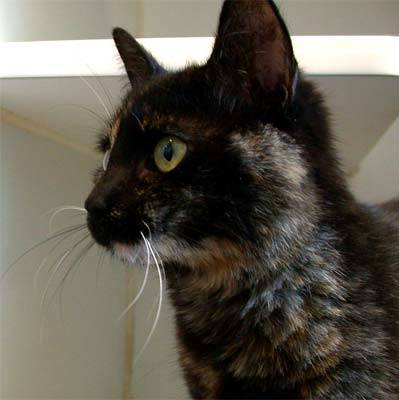

In [30]:
Image('/content/data/test/5.jpg')

In [31]:
print("Test data count: ", len(test))

print('Prediction Started!')

hypothesis_t = []
prediction_t = []

total_batch = int(len(test) / batch_size)

for i in range(total_batch):
    start_idx = i       * batch_size;
    end_idx   = (i + 1) * batch_size;

    batch_xs  = test       [start_idx:end_idx,:,:,:]

    h, p = sess.run([hypothesis, prediction], feed_dict={X: batch_xs, is_train:False})
    
    hypothesis_t.extend(h)
    prediction_t.extend(p)
    print(h)

print('Prediction Finished!')

Test data count:  12500
Prediction Started!
[[1.53095394e-01 8.46904635e-01]
 [8.50790646e-04 9.99149203e-01]
 [4.10296202e-01 5.89703858e-01]
 [3.75052951e-02 9.62494671e-01]
 [9.96063173e-01 3.93678667e-03]
 [4.69580293e-01 5.30419707e-01]
 [9.99998450e-01 1.55343548e-06]
 [5.68262815e-01 4.31737185e-01]
 [9.71570969e-01 2.84290444e-02]
 [9.86434937e-01 1.35650830e-02]
 [9.99999046e-01 9.43462055e-07]
 [5.62433191e-02 9.43756700e-01]
 [4.91936505e-01 5.08063495e-01]
 [6.42764807e-01 3.57235223e-01]
 [7.22762227e-01 2.77237803e-01]
 [9.81453180e-01 1.85467545e-02]
 [1.53170928e-01 8.46829116e-01]
 [3.19300219e-02 9.68069971e-01]
 [9.62594867e-01 3.74050960e-02]
 [6.71713412e-01 3.28286558e-01]
 [3.14356357e-01 6.85643673e-01]
 [9.70532894e-01 2.94671468e-02]
 [8.24580938e-02 9.17541921e-01]
 [4.53545600e-02 9.54645455e-01]
 [8.88724327e-02 9.11127508e-01]
 [2.44972423e-01 7.55027533e-01]
 [3.93063188e-01 6.06936812e-01]
 [9.99999285e-01 7.09792289e-07]
 [4.20390248e-01 5.79609692e-01]

[[3.11800480e-01 6.88199461e-01]
 [6.70269583e-05 9.99933004e-01]
 [8.90844226e-01 1.09155796e-01]
 [6.88870251e-01 3.11129779e-01]
 [5.41959584e-01 4.58040357e-01]
 [6.09936595e-01 3.90063435e-01]
 [2.49531701e-01 7.50468314e-01]
 [2.27705645e-03 9.97722924e-01]
 [8.65343139e-02 9.13465619e-01]
 [7.96866342e-02 9.20313299e-01]
 [9.22844231e-01 7.71557093e-02]
 [9.99876261e-01 1.23680104e-04]
 [8.64246845e-01 1.35753125e-01]
 [4.69068825e-01 5.30931115e-01]
 [6.82949960e-01 3.17050040e-01]
 [5.15429795e-01 4.84570146e-01]
 [9.88023937e-01 1.19760754e-02]
 [9.98809099e-01 1.19089184e-03]
 [9.96488452e-01 3.51152639e-03]
 [4.74166602e-01 5.25833368e-01]
 [9.64741290e-01 3.52586992e-02]
 [9.55650568e-01 4.43494059e-02]
 [5.63725173e-01 4.36274856e-01]
 [9.93643641e-01 6.35632919e-03]
 [9.96353507e-01 3.64646479e-03]
 [4.22747850e-01 5.77252090e-01]
 [3.77087295e-01 6.22912645e-01]
 [9.80974495e-01 1.90254934e-02]
 [7.48261631e-01 2.51738369e-01]
 [2.30076537e-01 7.69923449e-01]
 [6.689102

[[1.15866646e-01 8.84133399e-01]
 [1.07980622e-02 9.89202023e-01]
 [1.34744048e-02 9.86525655e-01]
 [3.96198958e-01 6.03801072e-01]
 [7.71561623e-01 2.28438333e-01]
 [8.40733707e-01 1.59266278e-01]
 [9.71258283e-01 2.87417602e-02]
 [4.91162091e-02 9.50883746e-01]
 [6.82097599e-02 9.31790292e-01]
 [9.76201147e-03 9.90238011e-01]
 [9.94790316e-01 5.20970626e-03]
 [5.23059011e-01 4.76941019e-01]
 [8.20683777e-01 1.79316163e-01]
 [3.62785970e-04 9.99637246e-01]
 [2.73365099e-02 9.72663522e-01]
 [9.66756701e-01 3.32432687e-02]
 [9.20662135e-02 9.07933772e-01]
 [5.89398503e-01 4.10601497e-01]
 [1.50348186e-01 8.49651814e-01]
 [9.63557482e-01 3.64425443e-02]
 [8.38478561e-04 9.99161482e-01]
 [8.23787451e-01 1.76212564e-01]
 [4.48748498e-04 9.99551237e-01]
 [9.28899169e-01 7.11007640e-02]
 [6.21908784e-01 3.78091246e-01]
 [9.93010104e-01 6.98984694e-03]
 [3.23225200e-01 6.76774800e-01]
 [1.97078399e-02 9.80292141e-01]
 [1.63868917e-05 9.99983668e-01]
 [8.24417651e-01 1.75582364e-01]
 [1.456639

[[5.63949049e-01 4.36050981e-01]
 [2.48441264e-01 7.51558661e-01]
 [3.36259604e-04 9.99663711e-01]
 [9.96029615e-01 3.97037761e-03]
 [8.57630849e-01 1.42369136e-01]
 [9.65365469e-02 9.03463423e-01]
 [8.51225853e-01 1.48774162e-01]
 [9.99637723e-01 3.62306047e-04]
 [9.91216421e-01 8.78353696e-03]
 [1.00000000e+00 5.86333435e-08]
 [1.81218028e-01 8.18781972e-01]
 [7.13129401e-01 2.86870629e-01]
 [7.55783021e-01 2.44216964e-01]
 [9.48509097e-01 5.14908731e-02]
 [4.20292318e-01 5.79707682e-01]
 [1.17192823e-04 9.99882817e-01]
 [5.78136921e-01 4.21863139e-01]
 [1.39606819e-01 8.60393167e-01]
 [6.36309385e-01 3.63690615e-01]
 [6.65016651e-01 3.34983349e-01]
 [7.51147628e-01 2.48852342e-01]
 [2.22923353e-01 7.77076662e-01]
 [1.17075592e-02 9.88292396e-01]
 [8.62073481e-01 1.37926534e-01]
 [4.39817488e-01 5.60182512e-01]
 [2.71993905e-01 7.28006065e-01]
 [5.95528213e-03 9.94044721e-01]
 [2.24900758e-03 9.97750938e-01]
 [9.99983907e-01 1.60635100e-05]
 [4.45800871e-01 5.54199100e-01]
 [1.473203

[[4.24563289e-02 9.57543671e-01]
 [9.84064221e-01 1.59358270e-02]
 [9.73946035e-01 2.60539185e-02]
 [1.42976210e-01 8.57023776e-01]
 [1.53683424e-02 9.84631658e-01]
 [9.32070851e-01 6.79290742e-02]
 [5.39507687e-01 4.60492283e-01]
 [3.74124316e-03 9.96258736e-01]
 [9.97322381e-01 2.67765485e-03]
 [6.08050823e-01 3.91949236e-01]
 [3.93843232e-03 9.96061504e-01]
 [5.61176419e-01 4.38823551e-01]
 [8.38602602e-01 1.61397412e-01]
 [9.76611316e-01 2.33886596e-02]
 [2.71254815e-02 9.72874582e-01]
 [5.80672440e-06 9.99994159e-01]
 [3.00257560e-02 9.69974279e-01]
 [9.60093737e-01 3.99062447e-02]
 [8.19713101e-02 9.18028653e-01]
 [9.98103857e-01 1.89610396e-03]
 [7.82465219e-01 2.17534810e-01]
 [1.12798952e-01 8.87201011e-01]
 [1.51840433e-01 8.48159611e-01]
 [2.90520536e-03 9.97094750e-01]
 [8.77711549e-02 9.12228823e-01]
 [9.99618292e-01 3.81687772e-04]
 [3.24166715e-01 6.75833285e-01]
 [1.70354713e-02 9.82964575e-01]
 [5.23300886e-01 4.76699173e-01]
 [3.94571759e-03 9.96054292e-01]
 [8.767764

[[9.78265285e-01 2.17346866e-02]
 [9.99993086e-01 6.95043445e-06]
 [8.08784664e-01 1.91215292e-01]
 [8.54332924e-01 1.45667046e-01]
 [2.76341743e-04 9.99723613e-01]
 [7.81115413e-01 2.18884513e-01]
 [4.46633637e-01 5.53366363e-01]
 [4.79948282e-01 5.20051718e-01]
 [6.02175295e-01 3.97824734e-01]
 [6.78169906e-01 3.21830064e-01]
 [8.22201371e-01 1.77798614e-01]
 [7.54462898e-01 2.45537132e-01]
 [9.99788344e-01 2.11628911e-04]
 [6.71307445e-01 3.28692555e-01]
 [2.28222943e-05 9.99977231e-01]
 [2.82550342e-02 9.71744955e-01]
 [6.71677649e-01 3.28322291e-01]
 [4.73236442e-01 5.26763618e-01]
 [5.51063009e-02 9.44893658e-01]
 [9.88270938e-01 1.17290253e-02]
 [5.16006202e-02 9.48399425e-01]
 [9.40281034e-01 5.97190410e-02]
 [5.06770909e-02 9.49322879e-01]
 [6.68977618e-01 3.31022412e-01]
 [9.99914527e-01 8.54415266e-05]
 [1.63535208e-01 8.36464822e-01]
 [1.61411494e-01 8.38588536e-01]
 [2.82193571e-01 7.17806399e-01]
 [9.99957204e-01 4.27353589e-05]
 [8.71379256e-01 1.28620744e-01]
 [5.042596

[[2.9012942e-01 7.0987064e-01]
 [3.4894061e-03 9.9651057e-01]
 [9.6615034e-01 3.3849631e-02]
 [1.9968987e-01 8.0031019e-01]
 [9.8608691e-01 1.3913051e-02]
 [7.9814875e-01 2.0185125e-01]
 [3.3455029e-02 9.6654499e-01]
 [4.2203408e-01 5.7796592e-01]
 [2.5196283e-03 9.9748033e-01]
 [9.9617505e-01 3.8248831e-03]
 [1.7573714e-01 8.2426286e-01]
 [5.7547569e-01 4.2452428e-01]
 [7.7835059e-01 2.2164947e-01]
 [9.0459442e-01 9.5405579e-02]
 [2.8662226e-01 7.1337771e-01]
 [1.8369174e-02 9.8163086e-01]
 [4.9583077e-02 9.5041692e-01]
 [3.1445507e-02 9.6855450e-01]
 [9.3693659e-03 9.9063069e-01]
 [9.9534935e-01 4.6506645e-03]
 [1.3903910e-01 8.6096090e-01]
 [6.6935909e-01 3.3064094e-01]
 [1.4152788e-01 8.5847217e-01]
 [9.9165827e-01 8.3417445e-03]
 [9.9986506e-01 1.3489908e-04]
 [6.9768298e-01 3.0231699e-01]
 [1.3912882e-02 9.8608714e-01]
 [7.1724102e-02 9.2827588e-01]
 [2.5739259e-01 7.4260741e-01]
 [9.9777067e-01 2.2293471e-03]
 [6.8215072e-01 3.1784928e-01]
 [8.6742181e-01 1.3257816e-01]
 [1.3031

[[9.69018936e-01 3.09811067e-02]
 [2.16324702e-01 7.83675313e-01]
 [6.37344241e-01 3.62655699e-01]
 [1.57912774e-03 9.98420835e-01]
 [5.06774813e-04 9.99493241e-01]
 [1.60062611e-01 8.39937449e-01]
 [6.59749627e-01 3.40250432e-01]
 [1.00000000e+00 2.50375845e-08]
 [9.65175986e-01 3.48240398e-02]
 [1.36137605e-01 8.63862336e-01]
 [9.09503877e-01 9.04961526e-02]
 [9.99992371e-01 7.61425008e-06]
 [3.25007677e-01 6.74992323e-01]
 [8.17021668e-01 1.82978317e-01]
 [2.22674280e-05 9.99977708e-01]
 [9.94508445e-01 5.49153658e-03]
 [3.62148806e-02 9.63785052e-01]
 [9.98529911e-01 1.47009094e-03]
 [7.58599281e-01 2.41400763e-01]
 [2.18283802e-01 7.81716228e-01]
 [5.55576007e-05 9.99944448e-01]
 [5.04426584e-02 9.49557364e-01]
 [4.13945079e-01 5.86054862e-01]
 [4.09231395e-01 5.90768576e-01]
 [8.92960072e-01 1.07039914e-01]
 [2.38866545e-03 9.97611284e-01]
 [1.79356277e-01 8.20643723e-01]
 [9.79049981e-01 2.09500697e-02]
 [8.56851265e-02 9.14314926e-01]
 [7.63023019e-01 2.36976981e-01]
 [9.996720

[[5.13856411e-01 4.86143619e-01]
 [2.89934695e-01 7.10065305e-01]
 [1.47759318e-01 8.52240741e-01]
 [2.90435203e-03 9.97095704e-01]
 [6.01819336e-01 3.98180693e-01]
 [5.25902569e-01 4.74097461e-01]
 [8.70181143e-01 1.29818872e-01]
 [9.99966502e-01 3.35499863e-05]
 [2.64322668e-01 7.35677361e-01]
 [9.33760464e-01 6.62395656e-02]
 [6.63344622e-01 3.36655408e-01]
 [9.71790552e-01 2.82094162e-02]
 [9.92025793e-01 7.97423720e-03]
 [9.96501446e-01 3.49852419e-03]
 [9.99855518e-01 1.44431353e-04]
 [1.43925592e-01 8.56074393e-01]
 [2.34398365e-01 7.65601635e-01]
 [9.24443662e-01 7.55563453e-02]
 [5.53445399e-01 4.46554631e-01]
 [9.99747574e-01 2.52454716e-04]
 [9.99989390e-01 1.05935796e-05]
 [9.99623895e-01 3.76119424e-04]
 [3.42906713e-02 9.65709329e-01]
 [7.20761836e-01 2.79238224e-01]
 [3.49520475e-01 6.50479555e-01]
 [8.04900751e-02 9.19509888e-01]
 [3.43774934e-03 9.96562302e-01]
 [1.11509703e-01 8.88490260e-01]
 [1.59373552e-01 8.40626478e-01]
 [3.58505726e-01 6.41494274e-01]
 [3.784262

In [32]:
print(hypothesis_t)

[array([0.1530954 , 0.84690464], dtype=float32), array([8.5079065e-04, 9.9914920e-01], dtype=float32), array([0.4102962 , 0.58970386], dtype=float32), array([0.0375053, 0.9624947], dtype=float32), array([0.9960632 , 0.00393679], dtype=float32), array([0.4695803, 0.5304197], dtype=float32), array([9.9999845e-01, 1.5534355e-06], dtype=float32), array([0.5682628 , 0.43173718], dtype=float32), array([0.97157097, 0.02842904], dtype=float32), array([0.98643494, 0.01356508], dtype=float32), array([9.9999905e-01, 9.4346206e-07], dtype=float32), array([0.05624332, 0.9437567 ], dtype=float32), array([0.4919365, 0.5080635], dtype=float32), array([0.6427648 , 0.35723522], dtype=float32), array([0.7227622, 0.2772378], dtype=float32), array([0.9814532 , 0.01854675], dtype=float32), array([0.15317093, 0.8468291 ], dtype=float32), array([0.03193002, 0.96807   ], dtype=float32), array([0.96259487, 0.0374051 ], dtype=float32), array([0.6717134 , 0.32828656], dtype=float32), array([0.31435636, 0.6856437 

In [33]:
from google.colab import files

hp = np.array(hypothesis_t)

print(hp)

submission = pd.DataFrame({
        "id": range(1, len(test_images) + 1), 
        "label": hp[:, 1]
})

submission.to_csv('submission.csv', index=False)

submission = pd.read_csv('submission.csv')
submission.head()

files.download('submission.csv')

!rm 'submission.csv'

[[1.5309539e-01 8.4690464e-01]
 [8.5079065e-04 9.9914920e-01]
 [4.1029620e-01 5.8970386e-01]
 ...
 [3.1562659e-01 6.8437338e-01]
 [3.8793376e-03 9.9612063e-01]
 [9.9260783e-01 7.3922090e-03]]


12500
26
1 - Dog: [15.31%, 84.69%]
2 - Dog: [0.09%, 99.91%]
3 - Dog: [41.03%, 58.97%]
4 - Dog: [3.75%, 96.25%]
5 - Cat: [99.61%, 0.39%]
6 - Dog: [46.96%, 53.04%]
7 - Cat: [100.00%, 0.00%]
8 - Cat: [56.83%, 43.17%]
9 - Cat: [97.16%, 2.84%]
10 - Cat: [98.64%, 1.36%]
11 - Cat: [100.00%, 0.00%]
12 - Dog: [5.62%, 94.38%]
13 - Dog: [49.19%, 50.81%]
14 - Cat: [64.28%, 35.72%]
15 - Cat: [72.28%, 27.72%]
16 - Cat: [98.15%, 1.85%]
17 - Dog: [15.32%, 84.68%]
18 - Dog: [3.19%, 96.81%]
19 - Cat: [96.26%, 3.74%]
20 - Cat: [67.17%, 32.83%]
21 - Dog: [31.44%, 68.56%]
22 - Cat: [97.05%, 2.95%]
23 - Dog: [8.25%, 91.75%]
24 - Dog: [4.54%, 95.46%]
25 - Dog: [8.89%, 91.11%]
26 - Dog: [24.50%, 75.50%]


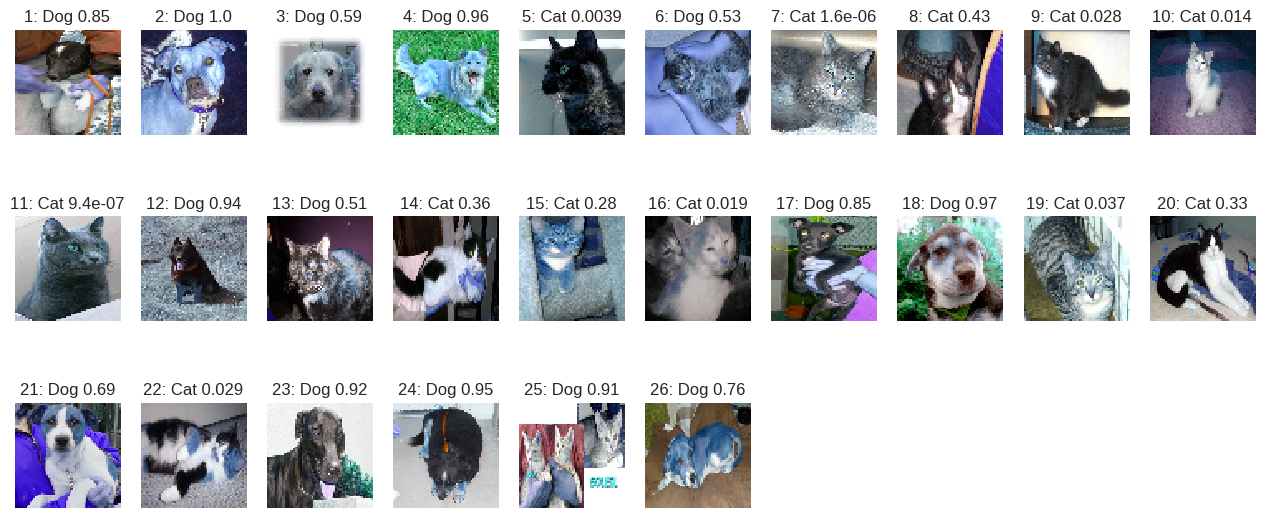

In [34]:
import math

print(len(test_images))
noReviewImage = int(min(len(test_images) * 0.002, 25))
test_images =  test_images[: (noReviewImage + 1)]
print(len(test_images))

plt.figure(figsize=(16,7),dpi=100,facecolor='white')

noSubPlotCol = 10
noSubPlotRow = math.ceil(len(test_images) / noSubPlotCol)

for i in range(len(test_images)):
    sort = ""
    
    if hp[int(i), 0] >= 0.5:
      sort = "Cat"
    else: 
      sort = "Dog"
      
    print('{} - {}: [{:.2%}, {:.2%}]'.format(i + 1, sort, hypothesis_t[i][0], hypothesis_t[i][1]))
        
    plt.subplot(noSubPlotRow,noSubPlotCol,i + 1)
    plt.imshow(test[i])
    plt.title('{}: {} {:.2}'.format(i + 1, sort, hypothesis_t[i][1]))
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])    


plt.show()

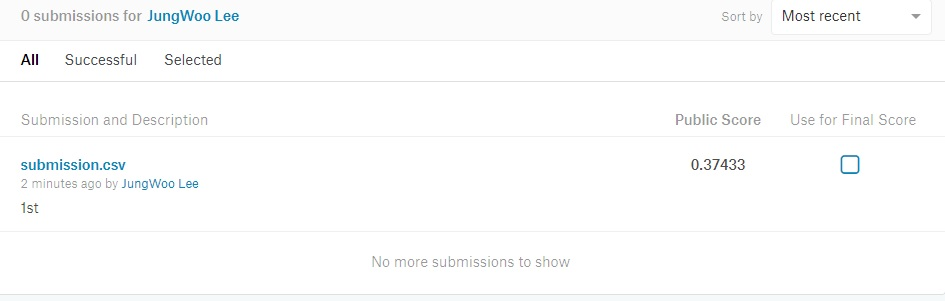

In [28]:
downloaded = drive.CreateFile({'id':'1qP-mRYZikDlNmgxnlyKPNOYnMmpK4lMn'}) # replace the id with id of file you want to access
downloaded.GetContentFile('111111.jpg')
Image('/content/111111.jpg')

# 메모리 부족 시 해결 방안

In [0]:
# !kill -9 -1
# 실제 위의 구문은 동작 중에 오류가 발생하는 경우도 있고, 
# VM이 잘 못 꼬이게 되면 런타임이 연결이 수시로 종료되거나, 연결이 실패 되는 경우가 발생
# 아직 해결책은 못참음

In [29]:
!ps ax | grep python

   90 ?        Sl     0:03 /usr/bin/python2 /usr/local/bin/jupyter-notebook -y --no-browser --log-level=DEBUG --debug --NotebookApp.allow_origin="*" --NotebookApp.log_format="%(message)s" --NotebookApp.token= --Session.key="" --Session.keyfile="" --ContentsManager.untitled_directory="Untitled Folder" --ContentsManager.untitled_file="Untitled File" --ContentsManager.untitled_notebook="Untitled Notebook" --NotebookNotary.algorithm="sha1" --KernelManager.autorestart=True --MultiKernelManager.default_kernel_name="python2" --ip="127.0.0.1" --port=9000 --port-retries=0 --notebook-dir="/content" --NotebookNotary.algorithm=sha256 --NotebookNotary.secret_file=/content/datalab/.config/notary_secret --NotebookApp.base_url=/tun/m/gpu-98c9098d-fee4-411b-ba92-e27b2e6c2709/
   98 ?        Ssl    1:25 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-be40f57f-9e8c-4140-817e-818e0b4133bc.json
  177 pts/0    Ss+    0:01 /bin/sh -c ps ax | grep python
  179 pts/0    S

In [0]:
# 아래와 같이 -1 대시 위의 확인된 번호로 접근해서 프로세스를 죽이는 것을 권장

#!kill -9 -322
#!kill -9 -349
#!kill -9 -366